# Practical Example with SIP Training

placeholder only, insert more complex SIP example 

...

In [77]:
dont run !!! import numpy as np
import tensorflow as tf
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"]=''  # set GPUs
#tf.config.run_functions_eagerly(True)  # deactivate Tensorflow Tracing

## Physics Model

Differential equation: Coupled Linear Oscillators with Control term

Solver: Runge-Kutta-4 

Nx: Number of oscillators,
Nt: Number of time evolution steps,
dt: Length of one time step

In [78]:
Nx = 2
Nt = 24
dt = 0.5

def build_laplace(n,boundary='0'):
    if n==1:
        return np.zeros((1,1),dtype=np.float32)
    d1 = -2 * np.ones((n,),dtype=np.float32)
    d2 = 1 * np.ones((n-1,),dtype=np.float32)
    lap = np.zeros((n,n),dtype=np.float32)
    lap[range(n),range(n)]=d1
    lap[range(1,n),range(n-1)]=d2
    lap[range(n-1),range(1,n)]=d2
    if boundary=='0':
        lap[0,0]=lap[n-1,n-1]=-1

    return lap

@tf.function
def coupled_oscillators_batch( x, control):
    print('coup harm osc tracing')
    '''
    ODE of type:    x' = f(x)
    :param x_in:    shape: (batch, 2 * number of osc)
                    order second index: x_i , v_i
    :param control: shape:(batch,)
    :return:
    '''
    n_osc = x.shape[1]//2

    # natural time evo
    a1 = np.array([[0,1],[-1,0]],dtype=np.float32)
    a2 = np.eye(n_osc,dtype=np.float32)
    A = np.kron(a1,a2)
    x_dot1 = tf.tensordot(x,A,axes = (1,1))

    # interaction term
    interaction_strength = 0.2
    b1 = np.array([[0,0],[1,0]],dtype=np.float32)
    b2 = build_laplace(n_osc)
    B = interaction_strength * np.kron(b1,b2)
    x_dot2 = tf.tensordot(x,B, axes=(1, 1))

    # control term
    control_vector = np.zeros((n_osc,),dtype=np.float32)
    control_vector[-1] = 1.0
    c1 = np.array([0,1],dtype=np.float32)
    c2 = control_vector
    C = np.kron(c1,c2)
    x_dot3 = tf.tensordot(control,C, axes=0)

    #all terms
    x_dot = x_dot1 + x_dot2 +x_dot3
    return x_dot

@tf.function
def runge_kutta_4_batch(x_0, dt, control, ODE_f_batch):

    f_0_0 = ODE_f_batch(x_0, control)
    x_14 = x_0 + 0.5 * dt * f_0_0

    f_12_14 = ODE_f_batch(x_14, control)
    x_12 = x_0 + 0.5 * dt * f_12_14

    f_12_12 = ODE_f_batch(x_12, control)
    x_34 = x_0 + dt * f_12_12

    terms = f_0_0 + 2 * f_12_14 + 2 * f_12_12 + ODE_f_batch(x_34, control)
    x1 = x_0 + dt * terms / 6

    return x1

@tf.function
def solver(x0, control):
    x = x0
    for i in range(Nt):
        x = runge_kutta_4_batch(x, dt, control[:,i], coupled_oscillators_batch)
    return x


## Network Model

In [79]:
act = tf.keras.activations.tanh
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2*Nx)),
    tf.keras.layers.Dense(20, activation=act),
    tf.keras.layers.Dense(20, activation=act),
    tf.keras.layers.Dense(20, activation=act),
    tf.keras.layers.Dense(Nt, activation='linear')
    ])

## Loss Function

In [80]:
@tf.function
def loss_function(a,b):
    diff = a-b
    loss_batch = tf.reduce_sum(diff**2,axis=1)
    loss = tf.reduce_sum(loss_batch)
    return loss

## Data set



In [81]:
N = 2**12
x_train = np.random.rand(N, 2 * Nx).astype(np.float32)
y_train = x_train

## Optimization
For the optimization procedure, we need to set up some parameters. 
1. Adam: The truncation parameter has no meaning here.
2. PG: The specified optimizer is the one used for network optimization. The physics inversion is done via Gauss-Newton and corresponds to an exact inversion since the physical optimization landscape is quadratic. For the Jacobian inversion in Gauss-Newton, we can specify a truncation parameter.
3. HIG: To receive the HIG algorithm, the optimizer has to be set to SGD. For the Jacobian half-inversion, we can specify a truncation parameter. Optimal batch sizes are typically lower. Learning rates can usually be chosen around 1.

Specify the maximal simulation time in seconds via max_number.

In [82]:
# Adam Training
if 0:
    mode = 'GD' 
    optimizer = tf.keras.optimizers.Adam
    batch_size = 256
    learning_rate = 0.001
    max_number = 30#*60
    trunc = 10**-10 

In [83]:
# PG training
if 0:
    mode = 'PG' 
    optimizer = tf.keras.optimizers.Adam
    batch_size = 256
    learning_rate = 0.001
    max_number = 30#*60
    trunc = 10**-10

In [84]:
# HIG training
if 1:
    mode = 'HIG' # GD, PG, HIG
    optimizer = tf.keras.optimizers.SGD
    batch_size = 32
    learning_rate = 1.0
    max_number = 30#*60
    trunc = 10**-10

Function to construct the half-inverse of matrix for HIGs

In [85]:
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util import dispatch
from tensorflow.python.util.tf_export import tf_export
from tensorflow.python.ops.linalg.linalg_impl import _maybe_validate_matrix,svd

@tf_export('linalg.gpinv')
@dispatch.add_dispatch_support
def gpinv(a, rcond=None,beta=0.5, validate_args=False, name=None):

  with ops.name_scope(name or 'pinv'):
    a = ops.convert_to_tensor(a, name='a')

    assertions = _maybe_validate_matrix(a, validate_args)
    if assertions:
      with ops.control_dependencies(assertions):
        a = array_ops.identity(a)

    dtype = a.dtype.as_numpy_dtype

    if rcond is None:

      def get_dim_size(dim):
        dim_val = tensor_shape.dimension_value(a.shape[dim])
        if dim_val is not None:
          return dim_val
        return array_ops.shape(a)[dim]

      num_rows = get_dim_size(-2)
      num_cols = get_dim_size(-1)
      if isinstance(num_rows, int) and isinstance(num_cols, int):
        max_rows_cols = float(max(num_rows, num_cols))
      else:
        max_rows_cols = math_ops.cast(
            math_ops.maximum(num_rows, num_cols), dtype)
      rcond = 10. * max_rows_cols * np.finfo(dtype).eps

    rcond = ops.convert_to_tensor(rcond, dtype=dtype, name='rcond')

    # Calculate pseudo inverse via SVD.
    # Note: if a is Hermitian then u == v. (We might observe additional
    # performance by explicitly setting `v = u` in such cases.)
    [
        singular_values,  # Sigma
        left_singular_vectors,  # U
        right_singular_vectors,  # V
    ] = svd(
        a, full_matrices=False, compute_uv=True)

    # Saturate small singular values to inf. This has the effect of make
    # `1. / s = 0.` while not resulting in `NaN` gradients.
    cutoff = rcond * math_ops.reduce_max(singular_values, axis=-1)
    singular_values = array_ops.where_v2(
        singular_values > array_ops.expand_dims_v2(cutoff, -1), singular_values**beta,
        np.array(np.inf, dtype))

    # By the definition of the SVD, `a == u @ s @ v^H`, and the pseudo-inverse
    # is defined as `pinv(a) == v @ inv(s) @ u^H`.
    a_pinv = math_ops.matmul(
        right_singular_vectors / array_ops.expand_dims_v2(singular_values, -2),
        left_singular_vectors,
        adjoint_b=True)

    if a.shape is not None and a.shape.rank is not None:
      a_pinv.set_shape(a.shape[:-2].concatenate([a.shape[-1], a.shape[-2]]))

    return a_pinv

We define a Python class to organize the optimization algorithm. Using physics solver, network model, loss function and a data set. We compute loss values after each epoch. Each epoch consists of several mini batch updates. Depending on the optimization method, the mini batch update differs:
1. Adam: Compute loss gradient, then apply the Adam
2. PG: Compute loss gradient und physics Jacobian, invert them data-point-wise, define a modified loss to compute network updates
3. HIG: Compute loss gradient and network-physics Jacobian, then compute half-inversion

In [86]:
class Optimization():
    def __init__(self,model,solver,loss_function,x_train,y_train):
        self.model = model
        self.solver = solver
        self.loss_function = loss_function
        self.x_train = x_train
        self.y_train = y_train
        self.y_dim = y_train.shape[1]
        self.weight_shapes = [weight_tensor.shape for weight_tensor in self.model.trainable_weights]

    def set_params(self,batch_size,learning_rate,optimizer,max_number,mode,trunc):
        self.number_of_batches = N // batch_size
        self.max_number = max_number
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer(learning_rate)
        self.mode = mode
        self.trunc = trunc


    def computation(self,x_batch, y_batch):
        control_batch = self.model(y_batch)
        y_prediction_batch = self.solver(x_batch,control_batch)
        loss = self.loss_function(y_batch,y_prediction_batch)
        return loss


    @tf.function
    def gd_get_derivatives(self,x_batch, y_batch):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.computation(x_batch,y_batch)
            loss_per_dp = loss / self.batch_size
        grad = tape.gradient(loss_per_dp, self.model.trainable_variables)
        return grad


    @tf.function
    def pg_get_physics_derivatives(self,x_batch, y_batch): #physical grads

        with tf.GradientTape(persistent=True) as tape:
            control_batch = self.model(y_batch)
            tape.watch(control_batch)
            y_prediction_batch = self.solver(x_batch,control_batch)
            loss = self.loss_function(y_batch,y_prediction_batch)
            loss_per_dp = loss / self.batch_size

        jacy = tape.batch_jacobian(y_prediction_batch,control_batch)
        grad = tape.gradient(loss_per_dp, y_prediction_batch)
        return jacy,grad,control_batch

    @tf.function
    def pg_get_network_derivatives(self,x_batch, y_batch,new_control_batch): #physical grads

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            control_batch = self.model(y_batch)
            loss = self.loss_function(new_control_batch,control_batch)
            #y_prediction_batch = self.solver(x_batch,control_batch)
            #loss = self.loss_function(y_batch,y_prediction_batch)
            loss_per_dp = loss / self.batch_size



        network_grad = tape.gradient(loss_per_dp, self.model.trainable_variables)
        return network_grad

    @tf.function
    def hig_get_derivatives(self,x_batch,y_batch):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            control_batch = self.model(y_batch)
            y_prediction_batch = self.solver(x_batch,control_batch)
            loss = self.loss_function(y_batch,y_prediction_batch)
            loss_per_dp = loss / self.batch_size

        jacy = tape.jacobian(y_prediction_batch, self.model.trainable_variables, experimental_use_pfor=True)
        loss_grad = tape.gradient(loss_per_dp, y_prediction_batch)
        return jacy, loss_grad



    def mini_batch_update(self,x_batch, y_batch):
        if self.mode=="GD":
            grad = self.gd_get_derivatives(x_batch, y_batch)
            self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))

        elif self.mode=="PG":
            jacy,grad,control_batch = self.pg_get_physics_derivatives(x_batch, y_batch)
            grad_e = tf.expand_dims(grad,-1)
            pinv = tf.linalg.pinv(jacy,rcond=10**-5)
            delta_control_label_batch = (pinv@grad_e)[:,:,0]
            new_control_batch = control_batch - delta_control_label_batch
            network_grad = self.pg_get_network_derivatives(x_batch, y_batch,new_control_batch)
            self.optimizer.apply_gradients(zip(network_grad, self.model.trainable_weights))

        elif self.mode =='HIG':
            jacy, grad = self.hig_get_derivatives(x_batch, y_batch)
            flat_jacy_list = [tf.reshape(jac, (self.batch_size * self.y_dim, -1)) for jac in jacy]
            flat_jacy = tf.concat(flat_jacy_list, axis=1)
            flat_grad = tf.reshape(grad, (-1,))
            inv = gpinv(flat_jacy, rcond=self.trunc)
            processed_derivatives = tf.tensordot(inv, flat_grad, axes=(1, 0))
            #processed_derivatives = self.linear_solve(flat_jacy, flat_grad)
            update_list = []
            l1 = 0
            for k, shape in enumerate(self.weight_shapes):
                l2 = l1 + np.prod(shape)
                upd = processed_derivatives[l1:l2]
                upd = np.reshape(upd, shape)
                update_list.append(upd)
                l1 = l2
            self.optimizer.apply_gradients(zip(update_list, self.model.trainable_weights))


    def epoch_update(self):
        for batch_index in range(self.number_of_batches):
            position = batch_index * batch_size
            x_batch = self.x_train[position:position + batch_size]
            y_batch = self.y_train[position:position + batch_size]
            self.mini_batch_update(x_batch, y_batch)

    def eval(self,epoch,wc_time,ep_dur):

        print('Epoch: ', epoch,' WallClockTime: ',wc_time,' EpochDuration: ',ep_dur )

        train_loss = self.computation(self.x_train,self.y_train)
        train_loss_per_dp = train_loss / N
        print('TrainLoss:', train_loss_per_dp)
        return train_loss_per_dp

    def start_training(self):
        init_loss = self.eval(0,0,0)
        init_time = time.time()
        time_list = [init_time]
        loss_list = [init_loss]

        epoch=0
        wc_time = 0

        while wc_time<max_number:
            
            duration = time.time()
            self.epoch_update()
            duration = time.time()-duration

            epoch += 1
            wc_time += duration

            loss = self.eval(epoch,wc_time,duration)
            time_list.append(duration)
            loss_list.append(loss)

        time_list = np.array(time_list)
        loss_list = np.array(loss_list)
        time_list[0] = 0
        return time_list, loss_list

Start the simulation.

In [87]:
opt = Optimization(model,solver,loss_function,x_train,y_train)
opt.set_params(batch_size,learning_rate,optimizer,max_number,mode,trunc)
time_list, loss_list = opt.start_training()

Epoch:  0  WallClockTime:  0  EpochDuration:  0
coup harm osc tracing
TrainLoss: tf.Tensor(1.0081012, shape=(), dtype=float32)
coup harm osc tracing
Epoch:  1  WallClockTime:  27.670811891555786  EpochDuration:  27.670811891555786
TrainLoss: tf.Tensor(6.0117705e-05, shape=(), dtype=float32)
Epoch:  2  WallClockTime:  30.26737689971924  EpochDuration:  2.596565008163452
TrainLoss: tf.Tensor(1.1014066e-05, shape=(), dtype=float32)


Plot and save data

dict_keys(['HIG'])


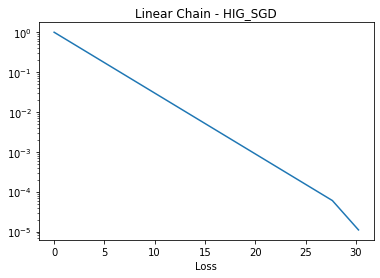

In [88]:
import matplotlib.pyplot as plt

wct_times = {}
wct_times[mode] = wct_time
print(format(wct_times.keys()))

wct_time = np.cumsum(time_list)
plt.plot(wct_time,loss_list)
plt.yscale('log')
plt.xlabel('Wall clock time')
plt.xlabel('Loss')
plt.title('Linear Chain - '+mode+'_'+str(optimizer.__name__))
plt.show()


In [89]:
path = './'
name1 = 'time'+mode
name2 = 'loss'+mode
np.savetxt(path+name1+'.txt',time_list)
np.savetxt(path+name2+'.txt',loss_list)